## To Dos
<ol>
    <li> PLS-DA for comparison</li>
    <li> What other EDA can be performed?</li>
    <li> Explore using NN, finish reading paper NN paper</li>
    <li> Hyperparater tuning with new train_test_split</li>
    <li></li>
    <li></li>
    <li></li>
    <li> Introduction and Conclusion</li>
</ol>

# Strawberry Classification via mid-IR Spectra

## Introduction

Classification of IR spectra was one of the first hallmarks of chemometrics. Karl Norris in the 1970's found a use for NIR spectra uisng chemometric models such as partial least squares (PLS). PLS has been used for years in regression analysis when there is a high number of features expressing multicollinearity. Because of the similarities in linearity between wavenumbers, PLS is a prime candidate for extracting meaningful information from IR spectra... 

### Question

Would one of the more modern machine learning techniques such as boosting, random forest, or k-nearest neighbors provide a better prediction accuracy than partial least squares? **Try NN like the second paper?**

### Data / Libraries

The data used is from the original spectra used by Holland, Kemsley, and Wilson<sup>2</sup>.

In [10]:
import pandas as pd
import numpy as np
import scipy.io as spy
import matplotlib.pyplot as plt
import re
from imblearn.over_sampling import SMOTE
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


df = pd.read_csv('MIR_Fruit_purees.csv')

In [16]:
df.shape

(983, 236)

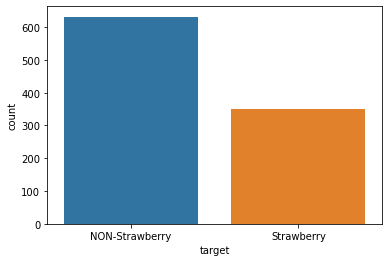

In [17]:
sns.countplot(x=df['target']);

## Data Cleaning

Fortunately, the date for this set is relatively clean. The only issue was the target variable being a string instead of an integer. All classification models used need integers in order to function properly. This is easily remedied using OneHot encoding through the `pd.get_dummies` function. 

In [4]:
df = pd.get_dummies(df, drop_first=True)

## Exploratory Data Analysis

One of the first things I like to explore in a new dataframe mean, std, and percentiles of the data. This is quickly done using `df.describe()`. 

In [5]:
df.describe()

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,target_Strawberry
count,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,...,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.00000
mean,0.002450,0.002465,0.002495,0.002604,0.002811,0.003044,0.003176,0.003174,0.003096,0.002994,...,0.000218,0.000139,0.000092,0.000062,0.000041,0.000029,0.000019,0.000009,0.000008,0.35707
std,0.000342,0.000351,0.000383,0.000428,0.000495,0.000596,0.000710,0.000792,0.000790,0.000718,...,0.000159,0.000122,0.000100,0.000078,0.000059,0.000039,0.000026,0.000011,0.000011,0.47938
min,0.001391,0.001389,0.001371,0.001472,0.001585,0.001667,0.001738,0.001754,0.001791,0.001836,...,-0.000073,-0.000061,-0.000050,-0.000049,-0.000084,-0.000023,-0.000055,-0.000014,-0.000014,0.00000
25%,0.002227,0.002226,0.002239,0.002313,0.002478,0.002642,0.002684,0.002633,0.002554,0.002505,...,0.000118,0.000067,0.000038,0.000023,0.000014,0.000013,0.000007,0.000004,0.000002,0.00000
50%,0.002449,0.002469,0.002494,0.002592,0.002779,0.002969,0.003054,0.003025,0.002948,0.002856,...,0.000192,0.000116,0.000074,0.000048,0.000031,0.000022,0.000014,0.000008,0.000007,0.00000
75%,0.002711,0.002728,0.002776,0.002916,0.003165,0.003427,0.003590,0.003601,0.003502,0.003362,...,0.000286,0.000183,0.000121,0.000079,0.000058,0.000036,0.000024,0.000012,0.000011,1.00000
max,0.003317,0.003450,0.003648,0.003943,0.004506,0.005230,0.005935,0.006418,0.006391,0.005979,...,0.001495,0.001423,0.001319,0.001122,0.000889,0.000644,0.000380,0.000187,0.000187,1.00000


Looking at the mean of the `target_Strawberry` shows that this is a somewhat imbalanced data sets. Any result from the model will likely favor the negative results, or not strawberry. Imbalanced data tends to still have a fine result for accuracy, but the recall or precision can suffer as a result. In this case, recall due to being more 0 values than 1. Something to keep in mind going forward.

Now, lets plot a few different ways to look at the data. First, I will plot all of the data together. Then I will separate the data into 'strawberry' and 'not strawberry' data sets to see how the two compare. Finally, I will take the mean of both and plot them on top of eachother to see what that looks like.

Before any plots can be made, it is important to drop the target column from each data frame. When comparing the strawberry vs. not strawberry, the target column does not need to be retained. However, for the complete data set used for predictions, I'll keep the target as my `y` variable to be used later in the modeling.

In [6]:
SPEC_RANGE = np.linspace(899, 1802.6, 235)

In [ ]:
X = df.drop('target_Strawberry', axis=1)
y = df['target_Strawberry']
X = (1 - X) * 100

In [ ]:
strawberry = df.loc[df['target_Strawberry'] == 0]
strawberry = strawberry.drop('target_Strawberry', axis=1)
strawberry = (1 - strawberry) * 100
not_strawberry = df.loc[df['target_Strawberry'] == 1]
not_strawberry = not_strawberry.drop('target_Strawberry', axis=1)
not_strawberry = (1 - not_strawberry) * 100

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(SPEC_RANGE, X.T.values);
ax.set_xlabel('Wavenumbers');
ax.set_ylabel('Transmittance');
ax.set_title('All mid-IR Spectra Data');
ax.invert_xaxis()
fig.savefig('All spectra.png')

In [ ]:
fig, ax = plt.subplots(2,1, sharey=True, figsize=(15,10))
ax[0].plot(SPEC_RANGE, strawberry.T.values);
ax[0].set_ylabel('Transmittance');
ax[0].set_title('Scans with Strawberry');
ax[0].invert_xaxis()

ax[1].plot(SPEC_RANGE, not_strawberry.T.values);
ax[1].set_ylabel('Transmittance');
ax[1].set_xlabel('Wavenumbers');
ax[1].set_title('Scans without Strawberry');
ax[1].invert_xaxis()

## Modeling

With the exploratory stage complete, it is time to start modeling the data. The 'modern' models that are going to be used will be K-nearest neighbors, random forest and boosting. Boosting and random forest use decision trees to make their predictions. While random forest uses a more randomized approach to check different feature columns (in this case wavenumbers) and values, boosting learns from each iteration to try and improve upon the previous iteration. K-nearest neighbors (KNN) is classification technique used to predict an unknown value by looking at the labels of points similar. The K value is the number of neighbors looked at near the unknown. The highest total from the labeled neighbors determines what the unknown prediction will be.

It is important, especially for KNN, for the data to be normalized. This is quickly performed using StandardScaler from sklearn. Because of the imbalance of the data, more than double of the not-strawberry samples vs. strawberry, it might be wise to run an imbalance technique known as Synthetic Minority Oversampling Technique (SMOTE).

Hyper parameter tuning is crucial for each of these and will help to fine tune the best parameters for the models.

At the finish, both models will be placed in an ensemble Voting Classifier in order to compare how each 'voted' to get the best result from the models.  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

sm = SMOTE(random_state=1)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

In [ ]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_scaled,y_train);

y_pred = rf.predict(X_test_scaled)

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
boost = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'auc', seed=42)

model_boost = boost.fit(X_train_scaled, y_train)

y_pred_boost = boost.predict(X_test_scaled)

acc_boost = classification_report(y_test, y_pred_boost)
print(acc_boost)

cm_boost = confusion_matrix(y_test, y_pred_boost)
cm_boost

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
model_knn = knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

acc_knn = classification_report(y_test, y_pred_knn)
print(acc_knn)

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn

In [ ]:
classifiers = [('Random Forest', rf), ('Boosting', boost), ('KNN', knn)]

vc = VotingClassifier (estimators = classifiers)
vc.fit(X_train_scaled, y_train)

y_pred_vc = vc.predict(X_test_scaled)

acc_vc = classification_report(y_test, y_pred_vc)
print(acc_vc)

cm_vc = confusion_matrix(y_test, y_pred_vc)
cm_vc

## Conclusion
**Add Conclusion**


#### References
1. Paper =  https://onlinelibrary.wiley.com/doi/10.1002/(SICI)1097-0010(199802)76:2%3C263::AID-JSFA943%3E3.0.CO;2-F
2. Data = https://csr.quadram.ac.uk/example-datasets-for-download/
3. Another paper using NN = https://www.mdpi.com/1424-8220/20/4/1223/htm#B1-sensors-20-01223